<a href="https://colab.research.google.com/github/Eddy-Santiago/El_Quimbo/blob/main/Quimbo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install  rasterio

import rasterio
from rasterio import *
from rasterio.plot import show
import numpy as np #Vectors
import pandas as pd #Dataset
import matplotlib.pyplot as plt #Visualization
import seaborn as sns #Visualization
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split #ML - Train, Test set.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 21.6 MB/s eta 0:00:00


In [2]:
#Constant
RANDOM_STATE = 15
TEST_SIZE = .3

In [3]:
data = pd.read_csv('/content/Training_dataset.csv')
data.columns

Index(['AGB (kg)', 'NDVI', 'SAVI', 'EVI', 'GNDVI', 'WDVI', 'SR', 'NDWI',
       'NDI45', 'MTCI', 'RENDVI'],
      dtype='object')

<Axes: >

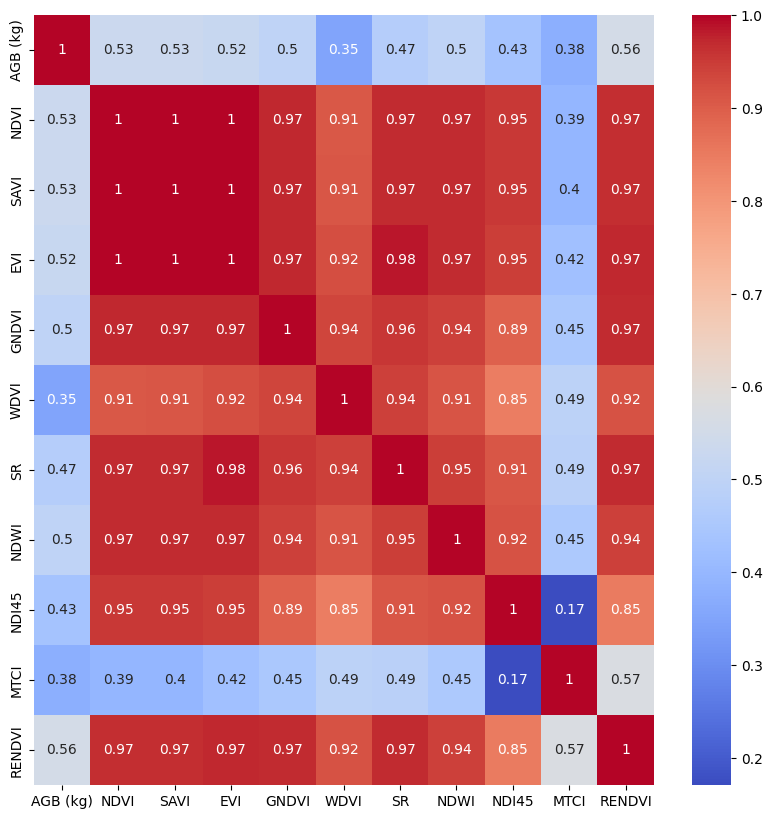

In [4]:
# calculate correlation matrix
corr = data.corr()# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap='coolwarm')

In [5]:
#Split data X and Y values.
from sklearn.preprocessing import StandardScaler

X = data.drop('AGB (kg)', axis = 1)
y = data.loc[:,['AGB (kg)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

'''
Scaler = StandardScaler()
Scaler.fit(X_train)
X_train = Scaler.transform(X_train)
X_test = Scaler.transform(X_test)'''

In [6]:
from sklearn import metrics
def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(test_labels, y_pred))
    print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(test_labels, y_pred)))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_labels, y_pred))
    print('R2:', metrics.r2_score(test_labels, y_pred))

In [7]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators = 200, criterion = 'squared_error', max_depth = None, random_state = RANDOM_STATE)
random_forest.fit(X_train, y_train)
evaluate(random_forest, X_test, y_test)

Mean Absolute Error (MAE): 443.70909620014316
Root Mean Squared Error (RMSE): 711.5982649847582
Mean Squared Error (MSE): 506372.0907293182
R2: 0.900648523655923


(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)


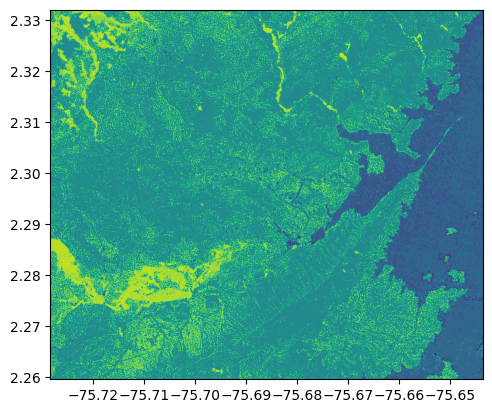

In [9]:
# Predecir a nivel de paisaje
# Cargar los datos de la imagen compuesta raster
raster_path = '/content/PREDICT.tif'
raster = rasterio.open(raster_path)

# Extraer las bandas correspondientes a las características que se utilizaron para entrenar el modelo
bands = X.columns
data_2 = []
print(raster.indexes)
for i, band in enumerate(bands):
    data_2.append(raster.read(i + 1))

    # Apilar las bandas en una matriz 2D
data_2 = np.stack(data_2, axis=-1)
data_2 = np.reshape(data_2, (-1, len(bands)))

data_2 = np.nan_to_num(data_2, nan=0)

#data_2 = Scaler.transform(data_2)

result = random_forest.predict(data_2)


# Guardar mean predicciones en una nueva banda de la imagen raster
profile = raster.profile
profile.update(dtype=rasterio.float32, count=1)
with rasterio.open('/content/Prediccion_RF.tif', 'w', **profile) as dst:
    dst.write( result.reshape((raster.height, raster.width)), 1)


# Visualizar el mapa
# Cargamos el archivo raster
src = rasterio.open('/content/Prediccion_RF.tif')

# Creamos una figura y un eje con matplotlib
fig, ax = plt.subplots()

# Utilizamos la función show de rasterio para visualizar el raster
show(src, ax=ax)

# Mostramos la figura con matplotlib
plt.show()

In [10]:
import xgboost as xgb #Model XGBoost

xgb_classifier = xgb.XGBRegressor(n_estimators=200, max_depth = None,random_state = RANDOM_STATE)
xgb_classifier.fit(X_train,y_train)
evaluate(xgb_classifier, X_test, y_test)

Mean Absolute Error (MAE): 232.2048051972345
Root Mean Squared Error (RMSE): 568.0872564274086
Mean Squared Error (MSE): 322723.1309152203
R2: 0.9366809109470662


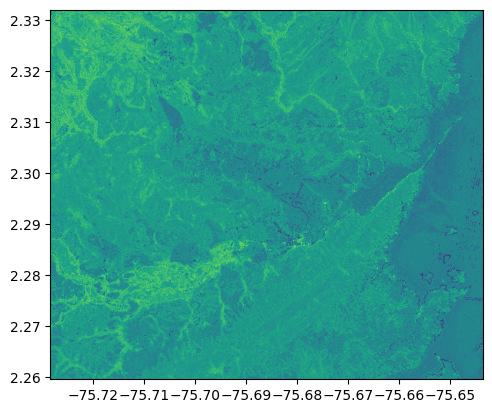

In [11]:
result = xgb_classifier.predict(data_2)


# Guardar mean predicciones en una nueva banda de la imagen raster
profile = raster.profile
profile.update(dtype=rasterio.float32, count=1)
with rasterio.open('/content/Prediccion_XGBOOST.tif', 'w', **profile) as dst:
    dst.write( result.reshape((raster.height, raster.width)), 1)


# Visualizar el mapa
# Cargamos el archivo raster
src = rasterio.open('/content/Prediccion_XGBOOST.tif')

# Creamos una figura y un eje con matplotlib
fig, ax = plt.subplots()

# Utilizamos la función show de rasterio para visualizar el raster
show(src, ax=ax)

# Mostramos la figura con matplotlib
plt.show()

In [12]:
#neural networks
from sklearn.neural_network import MLPRegressor
neural = MLPRegressor(hidden_layer_sizes = (30,30,30),
                      activation = 'relu',
                      solver = 'lbfgs',
                      max_iter = 500,
                      random_state=RANDOM_STATE)
neural.fit(X_train, y_train)
evaluate(neural, X_test, y_test)

Mean Absolute Error (MAE): 571.6258407423888
Root Mean Squared Error (RMSE): 915.2658059660596
Mean Squared Error (MSE): 837711.4955707006
R2: 0.8356389000122769


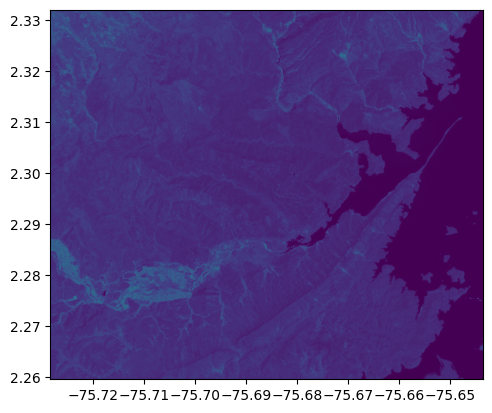

In [13]:
result = neural.predict(data_2)

# Guardar mean predicciones en una nueva banda de la imagen raster
profile = raster.profile
profile.update(dtype=rasterio.float32, count=1)
with rasterio.open('/content/Prediccion_NN.tif', 'w', **profile) as dst:
    dst.write( result.reshape((raster.height, raster.width)), 1)


# Visualizar el mapa
# Cargamos el archivo raster
src = rasterio.open('/content/Prediccion_NN.tif')

# Creamos una figura y un eje con matplotlib
fig, ax = plt.subplots()

# Utilizamos la función show de rasterio para visualizar el raster
show(src, ax=ax)

# Mostramos la figura con matplotlib
plt.show()

In [22]:
#Create Model - #WITHOUT SKLEARN
import tensorflow as tf

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(1024, activation = 'relu', input_shape = [10]),
                                    tf.keras.layers.Dropout(0.2),
                                    #tf.keras.layers.Dense(1024, activation = 'relu'),
                                    #tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(1024, activation = 'relu'),
                                    #tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(1024, activation = 'relu'),
                                    #tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(512, activation = 'relu'),
                                    tf.keras.layers.Dense(1)
                                    ])

# Compile the model
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error', metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [23]:
#Fit model
history = model.fit(X_train,
          y_train,
          epochs = 100,
          validation_split = 0.2,
)

Epoch 1/100
14/14 [==============================] - 3s 95ms/step - loss: 9785270.0000 - root_mean_squared_error: 3128.1416 - val_loss: 6311943.0000 - val_root_mean_squared_error: 2512.3582
Epoch 2/100
14/14 [==============================] - 1s 70ms/step - loss: 6978370.5000 - root_mean_squared_error: 2641.6606 - val_loss: 5803342.0000 - val_root_mean_squared_error: 2409.0127
Epoch 3/100
14/14 [==============================] - 1s 51ms/step - loss: 5413631.5000 - root_mean_squared_error: 2326.7212 - val_loss: 5496122.0000 - val_root_mean_squared_error: 2344.3809
Epoch 4/100
14/14 [==============================] - 1s 51ms/step - loss: 4165596.5000 - root_mean_squared_error: 2040.9792 - val_loss: 3852680.0000 - val_root_mean_squared_error: 1962.8245
Epoch 5/100
14/14 [==============================] - 1s 52ms/step - loss: 3124906.2500 - root_mean_squared_error: 1767.7405 - val_loss: 3038848.0000 - val_root_mean_squared_error: 1743.2292
Epoch 6/100
14/14 [==============================]

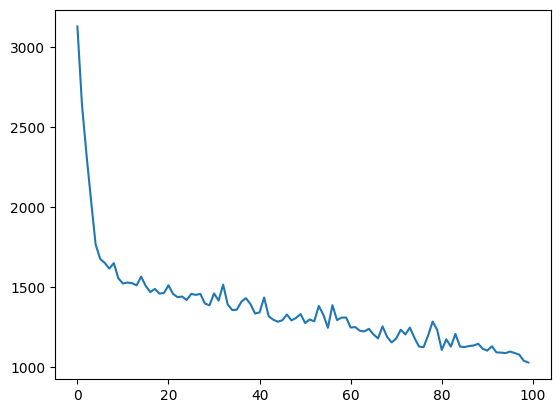

In [24]:
plt.plot(history.history['root_mean_squared_error'])
plt.show()

In [25]:
evaluate(model, X_test, y_test)

8/8 [==============================] - 0s 7ms/step
Mean Absolute Error (MAE): 723.213822439348
Root Mean Squared Error (RMSE): 1102.2206828728056
Mean Squared Error (MSE): 1214890.433752594
R2: 0.7616354447659768


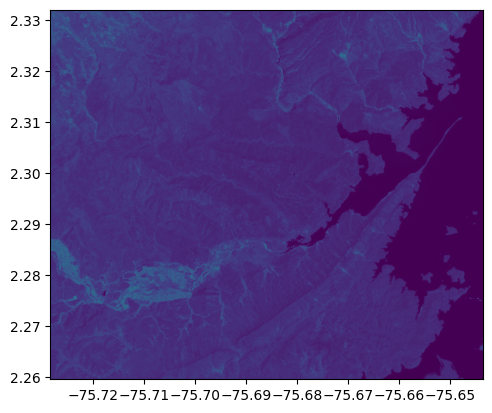

In [26]:
result = neural.predict(data_2)
#result = stack.predict(estimator=rf)


# Guardar mean predicciones en una nueva banda de la imagen raster
profile = raster.profile
profile.update(dtype=rasterio.float32, count=1)
with rasterio.open('/content/Prediccion_NN_KERAS.tif', 'w', **profile) as dst:
    dst.write( result.reshape((raster.height, raster.width)), 1)


# Visualizar el mapa
# Cargamos el archivo raster
src = rasterio.open('/content/Prediccion_NN_KERAS.tif')

# Creamos una figura y un eje con matplotlib
fig, ax = plt.subplots()

# Utilizamos la función show de rasterio para visualizar el raster
show(src, ax=ax)

# Mostramos la figura con matplotlib
plt.show()